In [1]:
import utils
import models
import numpy as np
import torch
import configs
import pgm_explainer as pe
from scipy.special import softmax
import pandas as pd
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

import argparse
    
def arg_parse():
    parser = argparse.ArgumentParser(description="Explainer arguments.")

    parser.add_argument(
            "--bmname", dest="bmname", help="Name of the benchmark dataset"
        )
    parser.add_argument("--dataset", dest="dataset", help="Input dataset.")
    parser.add_argument("--ckptdir", dest="ckptdir", help="Model checkpoint directory")
    parser.add_argument(
            "--gpu",
            dest="gpu",
            action="store_const",
            const=True,
            default=False,
            help="whether to use GPU.",
        )
    parser.add_argument(
            "--node-start", dest="node_start", type=int, help="Index of starting node."
        )
    parser.add_argument(
            "--node-end", dest="node_end", type=int, help="Index of ending node."
        )
    parser.add_argument(
            "--num-perturb-samples", dest="num_perturb_samples", type=int, help="Number of perturbed sample using to generate explanations."
        )
    parser.add_argument(
            "--top-node", dest="top_node", type=int, help="Number of nodes in explanation."
        )
    parser.add_argument(
            "--epochs", dest="num_epochs", type=int, help="Number of epochs to train."
        )
    parser.add_argument(
            "--hidden-dim", dest="hidden_dim", type=int, help="Hidden dimension"
        )
    parser.add_argument(
            "--output-dim", dest="output_dim", type=int, help="Output dimension"
        )
    parser.add_argument(
            "--num-gc-layers",
            dest="num_gc_layers",
            type=int,
            help="Number of graph convolution layers before each pooling",
        )
    parser.add_argument(
            "--bn",
            dest="bn",
            action="store_const",
            const=True,
            default=False,
            help="Whether batch normalization is used",
        )
    parser.add_argument("--dropout", dest="dropout", type=float, help="Dropout rate.")
    parser.add_argument(
            "--method", dest="method", type=str, help="Method. Possible values: base, att."
        )
    parser.add_argument(
            "--nobias",
            dest="bias",
            action="store_const",
            const=False,
            default=True,
            help="Whether to add bias. Default to True.",
        )
    
        # Explainer
   
    

    parser.set_defaults(
            ckptdir=None,
            dataset="syn1",
            opt="adam",  
            opt_scheduler="none",
            lr=0.1,
            clip=2.0,
            batch_size=20,
            num_epochs=100,
            hidden_dim=20,
            output_dim=20,
            num_gc_layers=3,
            method="base",
            dropout=0.0,
            node_start = None,
            node_end = None,
            num_perturb_samples = 100,
            top_node = None
        )
    
    return parser

d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prog_args = arg_parse()
args= prog_args.parse_args(['--dataset','syn1','--num-perturb-samples', '900','--top-node', '3'])

In [3]:
# Load model
A, X = utils.load_XA(args.dataset, datadir = "../Generate_XA_Data/XAL")
L = utils.load_labels(args.dataset, datadir = "../Generate_XA_Data/XAL")
num_classes = max(L) + 1
input_dim = X.shape[1]
num_nodes = X.shape[0]
ckpt = utils.load_ckpt(args)

print("input dim: ", input_dim, "; num classes: ", num_classes)
    
model = models.GcnEncoderNode(
        input_dim=input_dim,
        hidden_dim=args.hidden_dim,
        embedding_dim=args.output_dim,
        label_dim=num_classes,
        num_layers=args.num_gc_layers,
        bn=args.bn,
        args=args,
        )
model.load_state_dict(ckpt["model_state"]) 
pred = ckpt["save_data"]["pred"]

loading model
../Train_GNN_model/ckpt\syn1.pth.tar
=> loading checkpoint '../Train_GNN_model/ckpt\syn1.pth.tar'
input dim:  10 ; num classes:  4


In [4]:
import random
random.seed(21)

In [5]:
# Range of node to explain in this dataset is from 300 to 700
nodes_to_explain = list(range(400,700,5)) 

In [6]:
# Construct the explainer
explainer = pe.Node_Explainer(model, A, X, pred, 3)

Explainer settings
\ A dim:  (700, 700)
\ X dim:  (700, 10)
\ Number of layers:  3
\ Perturbation mode:  0
\ Print result:  1


In [7]:
import networkx as nx
import pylab as plt

def pgm_draw_nx(pgm_explanation):
    print("Draw pgm explaination using networkx")
    nx.draw(pgm_explanation, with_labels=True)
    plt.show()

def PGM_construct(pgm_explanation, target_name):
    loc = [(0, 0), (-5, -5), (5, -5), (5, 5), (-5,5)]
    pos = dict(zip(pgm_explanation.nodes(), loc))
    color_dict = dict(zip(range(pred.shape[2]), ['y','b','m','r']))
    color = [color_dict[ np.argmax(pred[0,int(node),:])] for node in pgm_explanation.nodes()]
    name_dict = [r'$A$',r'$B$',r'$C$',r'$D$',r'$E$']
    name = dict(zip(pgm_explanation.nodes(), name_dict))

    # gt_graph = nx.Graph()
    # gt_graph.add_nodes_from(pos.keys(), size=50)
    # edges_list = [('300', '301'),('301', '302'),('302', '300'),('303', '300'),('304', '300')]
    # gt_graph.add_edges_from(edges_list)

    # print("Ground truth explaination of node ", name[target_name])
    # figure1, ax1 = plt.subplots(figsize = (4,4))
    # ax1.axis('off')
    # nx.draw_networkx_nodes(gt_graph,pos,node_size=400,node_color= color)
    # nx.draw_networkx_edges(gt_graph,pos,
    #                     edgelist= edges_list,
    #                     width=2.0,alpha=1)
    # nx.draw_networkx_labels(gt_graph,pos,name,font_size=18, font_family = 'serif', font_weight = 'normal',
    #                         font_color = 'w')

    # # filename = 'view/motif_' + str(explained_node)+ '.jpg' 
    # # figure1.savefig(filename, dpi=90, bbox_inches='tight')

    print("PGM explaination of node ", name[target_name])

    figure2, ax = plt.subplots(figsize = (4,4))
    ax.axis('off')
    nx.draw_networkx_nodes(pgm_explanation,pos,node_size=400,node_color= color)
    nx.draw_networkx_edges(pgm_explanation,pos,
                        edgelist= pgm_explanation.edges,
                        connectionstyle='arc3, rad = 0.2',
                        width=2.0,alpha=0.8)
    nx.draw_networkx_labels(pgm_explanation,pos,name,font_size=18, font_family = 'serif', font_color = 'w')
    figure2.show()

    # filename = 'view/pgm_' + str(explained_node)+ '.jpg' 
    # figure2.savefig(filename, dpi=90, bbox_inches='tight')



--------------------------- Node 400 ---------------------------
Explaining node: 400


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\PGM_Node\Explain_GNN\pgm_explainer.py:91: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  X_torch = torch.tensor([self.X], dtype=torch.float)


MK-blanket of target node: [404, 402, 400]
Generate the PGM
PGM Nodes:  ['404', '402', '400']
PGM Edges:  [('404', '400'), ('402', '400')]
The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience
Compute marginal probability of the target prediction with no observation
0.20011162029386248
Target's label is:  1
Probability that the target's label is 1 given ['404'] is 0.24828189300411524
Probability that the target's label is 1 given ['404', '402'] is 0.3627906976744186
Draw pgm explaination using networkx


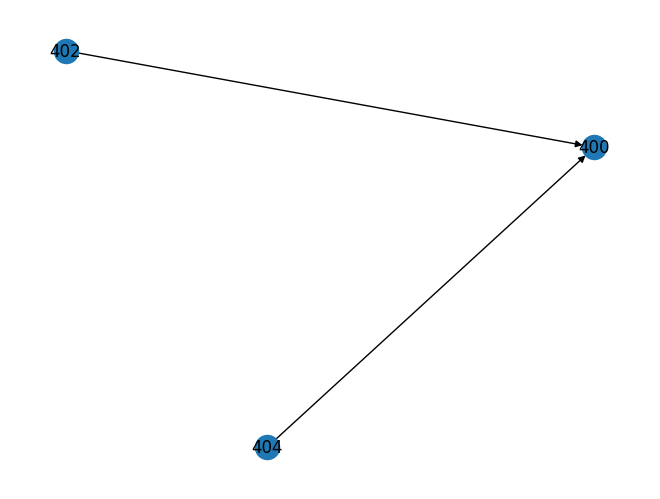

PGM explaination of node  $C$


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


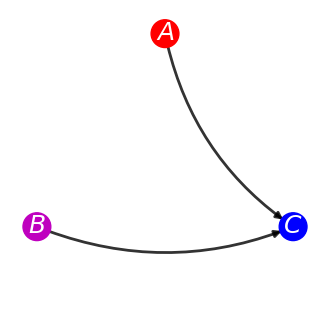

In [8]:
target = nodes_to_explain[0]

print(f"--------------------------- Node {target} ---------------------------")
# Explaining the target node
subnodes, data, stats = explainer.explain(target, num_samples = 900, top_node = 3, pred_threshold = 0.2)
# Markov Blanket of target node
print("MK-blanket of target node:", subnodes)

# Generating the Probabilistic Graph
print("Generate the PGM")
pgm_explanation = explainer.pgm_generate(target, data, stats, subnodes)
print("PGM Nodes: ", pgm_explanation.nodes())
print("PGM Edges: ", pgm_explanation.edges())

# Conversion of target names for preventing type mismatch
print("The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience")
target_name = str(target)
explaining_nodes = [node for node in pgm_explanation.nodes() if node != target_name]

# Computing marginal probability of target prediction with no observation
print("Compute marginal probability of the target prediction with no observation")
marginal_prob = explainer.pgm_conditional_prob(target_name, pgm_explanation, [])
print(marginal_prob)

# Computing other probabilities
target_label = np.argmax(pred[0,target])
print("Target's label is: ", target_label)
for num_of_evidence in range(len(explaining_nodes)):
    cond_prob = explainer.pgm_conditional_prob(target_name, pgm_explanation, explaining_nodes[0:num_of_evidence+1])
    print("Probability that the target's label is {} given {} is {}".format(target_label,
                                                                            explaining_nodes[0:num_of_evidence+1],
                                                                        cond_prob))


# Drawing pgm explanation
pgm_draw_nx(pgm_explanation)
PGM_construct(pgm_explanation, target_name)

In [9]:
# # Explaining each target node
# for target in nodes_to_explain:
#     print(f"--------------------------- Node {target} ---------------------------")
#     # Explaining the target node
#     subnodes, data, stats = explainer.explain(target, num_samples = 900, top_node = 3, pred_threshold = 0.2)
#     # Markov Blanket of target node
#     print("MK-blanket of target node:", subnodes)
    
#     # Generating the Probabilistic Graph
#     print("Generate the PGM")
#     pgm_explanation = explainer.pgm_generate(target, data, stats, subnodes)
#     print("PGM Nodes: ", pgm_explanation.nodes())
#     print("PGM Edges: ", pgm_explanation.edges())

#     # Conversion of target names for preventing type mismatch
#     print("The variables in the PGM is 'str' while the nodes' names in the dataset is 'int' so we convert them for convenience")
#     target_name = str(target)
#     explaining_nodes = [node for node in pgm_explanation.nodes() if node != target_name]

#     # Computing marginal probability of target prediction with no observation
#     print("Compute marginal probability of the target prediction with no observation")
#     marginal_prob = explainer.pgm_conditional_prob(target_name, pgm_explanation, [])
#     print(marginal_prob)

#     # Computing other probabilities
#     target_label = np.argmax(pred[0,target])
#     print("Target's label is: ", target_label)
#     for num_of_evidence in range(len(explaining_nodes)):
#         cond_prob = explainer.pgm_conditional_prob(target_name, pgm_explanation, explaining_nodes[0:num_of_evidence+1])
#         print("Probability that the target's label is {} given {} is {}".format(target_label,
#                                                                                 explaining_nodes[0:num_of_evidence+1],
#                                                                             cond_prob))
    

#     # Drawing pgm explanation
#     pgm_draw_nx(pgm_explanation)
#     PGM_construct(pgm_explanation, target_name)